In [1]:
import os
import json
import numpy as np
import datetime as dt
import math
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

# Initialization

## Set experiment dates

In [2]:
date_start = dt.datetime.strptime("2005-01-01", "%Y-%m-%d")
date_end = dt.datetime.strptime("2021-06-30", "%Y-%m-%d") 

## Set root directories

In [3]:
dir_root = os.path.join('..')
dir_data_processing = os.path.join(dir_root, "data_processing")
dir_data_runs = os.path.join(dir_root, "data_runs")

## Set reports directories

In [4]:
dir_reports_words = os.path.join(dir_data_processing, "reports_words")
dir_reports_terms = os.path.join(dir_data_processing, "reports_terms")
dir_reports_grams = os.path.join(dir_data_processing, "reports_gramms")
dir_reports_ready = os.path.join(dir_data_processing, "reports_ready")

## Set run directories

In [72]:
run_prefix = 'run_19-ext_22'
dir_run = os.path.join(dir_data_runs, run_prefix)
dir_result_interpretation = os.path.join(dir_run, 'interpretation')

## Set other paths

In [73]:
dir_tickers = os.path.join(dir_data_processing, 'tickers')

## Set time series

In [6]:
year_series = list(range(date_start.year, date_end.year)) 

In [7]:
print(year_series)

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


# Build dictionary of a run

In [8]:
file_terms = os.path.join(dir_run, '%s-terms.dat' % run_prefix)

In [9]:
dictionary_term2id = {}
dictionary_id2term = {}
term_id_counter = 0
with open(file_terms, 'r') as f_r:
    for text_line in f_r:
        term = text_line.strip()
        dictionary_term2id[term] = term_id_counter
        dictionary_term2id[term_id_counter] = term
        term_id_counter += 1
        
print('Size of fixed dictionary: %s ' % term_id_counter)

Size of fixed dictionary: 21719 


# Construct binary reports vectors

## Read names of reports

In [10]:
def expand_report_info(name):
    name = name.strip().split('.')[0]
    components = name.split('-')
    year, index = components[1].split('_')
    
    return {
        'name': name,
        'year': int(year),
        'ticker': components[0],
        'index': int(index),
    }

In [11]:
reports = [] #{name, year, ticker, index}
tickers = set()
with open(os.path.join(dir_run, '%s-documents.dat' % run_prefix), 'r') as f_r:
    for line in f_r:
        report = expand_report_info(line)
        tickers.add(report['ticker'])
        reports.append(report)

tickers_list = list(sorted(tickers))        

print('Read %s reports' % len(reports))
print('Read %s tickers' % len(tickers))

Read 5562 reports
Read 79 tickers


In [74]:
file_ticker_to_name = os.path.join(dir_tickers, 'tickers_names_map.csv')
companies_names = {}
with open(file_ticker_to_name, 'r') as f_r:
    for t_l in f_r:
        o = t_l.strip().split(',')
        companies_names[o[0]] = o[1]

## Map BOW to binary reports (P)

Read BOW for all reports

In [12]:
text_file = open(os.path.join(dir_run, '%s-mult.dat' % run_prefix), 'r')
reports_bow = text_file.readlines()

Construct P

In [13]:
P_by_year = {}

for ticker in tickers_list:
    p = {}
    for year in year_series:
        p[year] = np.zeros(term_id_counter)
    
    P_by_year[ticker] = p
    

for i, report in enumerate(reports):
    for j, term in enumerate(reports_bow[i].split(' ')):
        if j == 0: continue
        
        P_by_year[report['ticker']][report['year']][int(term.split(':')[0])] = 1
        

Test

In [14]:
test_ticker = 'AAL_FTSE'
test_year = 2007
total_term_in_P = 0
for appearance in P_by_year[test_ticker][test_year]:
    total_term_in_P += appearance 

    
print('%s in %s has %s unique terms' % (test_ticker, test_year, total_term_in_P))

AAL_FTSE in 2007 has 1886.0 unique terms


In [15]:
V_by_year = {}

for ticker in tickers_list:
    v = {}
    for year in year_series:
        v[year] = P_by_year[ticker][year] / np.sqrt(np.dot(P_by_year[ticker][year], np.ones(term_id_counter)))
        
    V_by_year[ticker] = v

In [16]:
test_ticker = 'AAL_FTSE'
test_year = 2007
v = None
    
print('%s in %s values in V scaled %s' % (test_ticker, test_year, np.max(V_by_year[test_ticker][test_year])))

AAL_FTSE in 2007 values in V scaled 0.0230265649529252


# Stability of a ticker (based on P)

Get number of 1s

In [17]:
def number_1s(x):
    return x.sum()

Get number of 0s

In [18]:
def number_0s(x):
    return len(x) - x.sum()

Partial Hamming distance: "Became 0"

In [19]:
def part_hamming_distance_0(x, y):
    distance = 0
    for i in range(len(x)):
        if x[i] == 1 and y[i] == 0:
            distance += 1
    
    return distance

Partial Hamming distance: "Became 1"

In [20]:
def part_hamming_distance_1(x, y):
    distance = 0
    for i in range(len(x)):
        if x[i] == 0 and y[i] == 1:
            distance += 1
    
    return distance

Hamming distance

In [41]:
def hamming_distance(x, y, normalise=True, assimilarity=False):
    distance = 0
    size = max(x.sum(), y.sum())
    diff = np.logical_xor(x, y)
    distance = diff.sum() 
    if normalise or assimilarity:
        distance /= size
    if assimilarity:
        distance = 1 - distance
        
    return distance

Jaccard similarity

In [22]:
def jaccard_similarity(x, y):
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    distance = intersection.sum() / float(union.sum())
    
    return distance

Hober-phillipps similarity

In [23]:
def hp_similarity(x, y):
    distance = np.dot(x, y)
    
    return distance

# Metrics table

In [24]:
data = {}
for ticker in tickers_list:
    ticker_p_years = P_by_year[ticker]
    data_0s = [number_0s(ticker_p_years[year_series[0]])]
    data_1s = [number_1s(ticker_p_years[year_series[0]])]
    turn_0s = []
    turn_1s = []
    for i in range(1, len(year_series)):
        data_0s.append(
            number_0s(ticker_p_years[year_series[i]])
        )
        data_1s.append(
            number_1s(ticker_p_years[year_series[i]])
        )
        turn_0s.append(
            part_hamming_distance_0(
                ticker_p_years[year_series[i - 1]],
                ticker_p_years[year_series[i]]))
        turn_1s.append(
            part_hamming_distance_1(
                ticker_p_years[year_series[i - 1]],
                ticker_p_years[year_series[i]]))                 
    
    data[ticker] = [
        np.array(data_0s).mean(),
        np.array(data_1s).mean(),
        np.array(turn_0s).mean(),
        np.array(turn_1s).mean()
    ]
    
df_data = pd.DataFrame(
            data = data,
            columns=tickers_list)    
    

In [25]:
print(df_data)

     AAL_FTSE       ACA_CAC        AC_CAC      ADM_FTSE      AGK_FTSE  \
0  19420.0625  19134.437500  21018.937500  20711.437500  20844.625000   
1   2298.9375   2584.562500    700.062500   1007.562500    874.375000   
2    495.0000    668.533333    270.333333    350.333333    283.000000   
3    626.0000    611.866667    216.200000    345.466667    373.133333   

        AIR_CAC       ALV_DAX     ANTO_FTSE    BAB_FTSE     BARC_FTSE  ...  \
0  19944.125000  19897.250000  20334.812500  20280.3125  19213.125000  ...   
1   1774.875000   1821.750000   1384.187500   1438.6875   2505.875000  ...   
2    544.933333    486.466667    337.133333    321.4000    519.066667  ...   
3    613.933333    638.866667    403.266667    401.6000    586.466667  ...   

       TVE_DJIA     ULVR_FTSE      UTX_DJIA  VED_FTSE      VOD_FTSE  \
0  19842.000000  19889.875000  20459.062500  19835.75  19255.250000   
1   1877.000000   1829.125000   1259.937500   1883.25   2463.750000   
2    368.533333    420.666667 

In [26]:
HTML_TEMPLATE1 = '''
<html>
<head>
<style>
  h2 {
    text-align: center;
    font-family: Helvetica, Arial, sans-serif;
  }
  table { 
    margin-left: auto;
    margin-right: auto;
  }
  table, th, td {
    border: 1px solid black;
    border-collapse: collapse;
  }
  th, td {
    padding: 5px;
    text-align: center;
    font-family: Helvetica, Arial, sans-serif;
    font-size: 90%;
  }
  table tbody tr:hover {
    background-color: #dddddd;
  }
  .wide {
    width: 90%; 
  }
</style>
</head>
<body>
'''

HTML_TEMPLATE2 = '''
</body>
</html>
'''

In [27]:
def to_html_pretty(df, filename='/tmp/out.html', title=''):
    '''
    Write an entire dataframe to an HTML file
    with nice formatting.
    Thanks to @stackoverflowuser2010 for the
    pretty printer see https://stackoverflow.com/a/47723330/362951
    '''
    ht = ''
    if title != '':
        ht += '<h2> %s </h2>\n' % title
    ht += df.to_html(classes='wide', escape=False)

    with open(filename, 'w') as f:
         f.write(HTML_TEMPLATE1 + ht + HTML_TEMPLATE2)

In [28]:
table_file = os.path.join(dir_run, 'interpretation', 'stability_table.html')

In [29]:
to_html_pretty(df_data.transpose(), filename=table_file)


Plot distance between consecutive

In [30]:
rows_on_page = 5
columns_on_page = 2
plots_on_page = rows_on_page * columns_on_page
number_of_pages = math.ceil(len(tickers) / plots_on_page)

In [31]:
dir_hp_similarity_plots = os.path.join(dir_result_interpretation, 'hoberg_phillipps_distance_plot')

if not os.path.exists(dir_hp_similarity_plots):
    os.makedirs(dir_hp_similarity_plots)

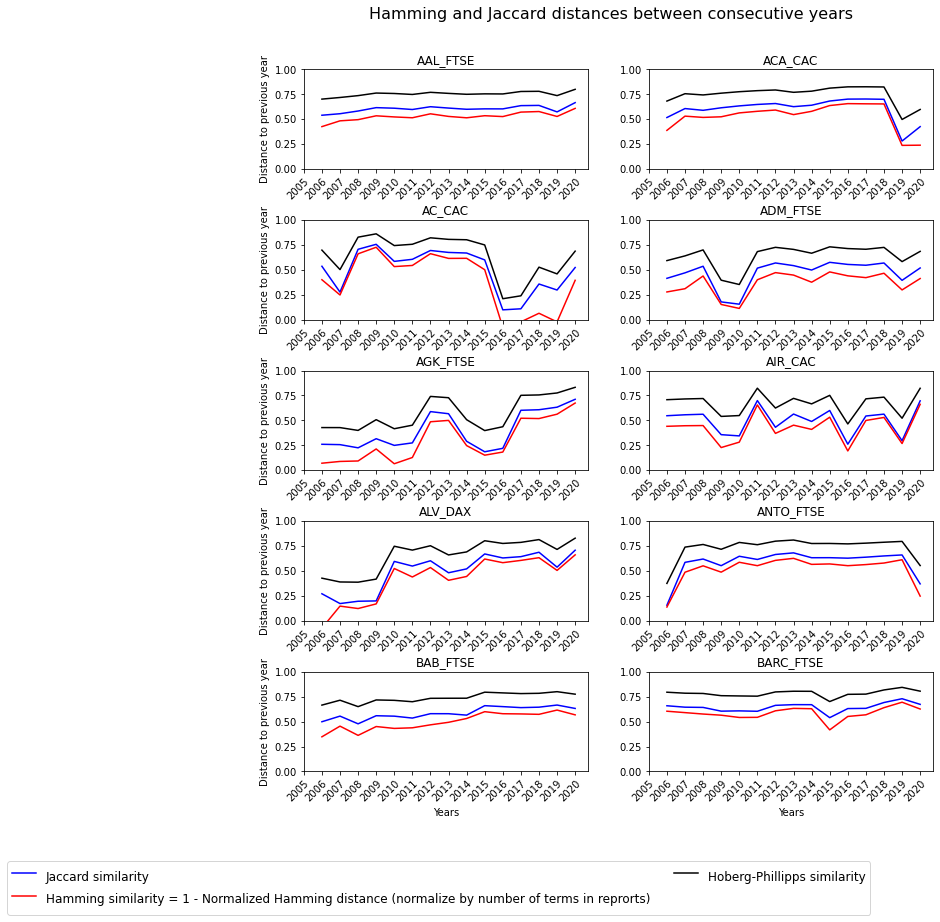

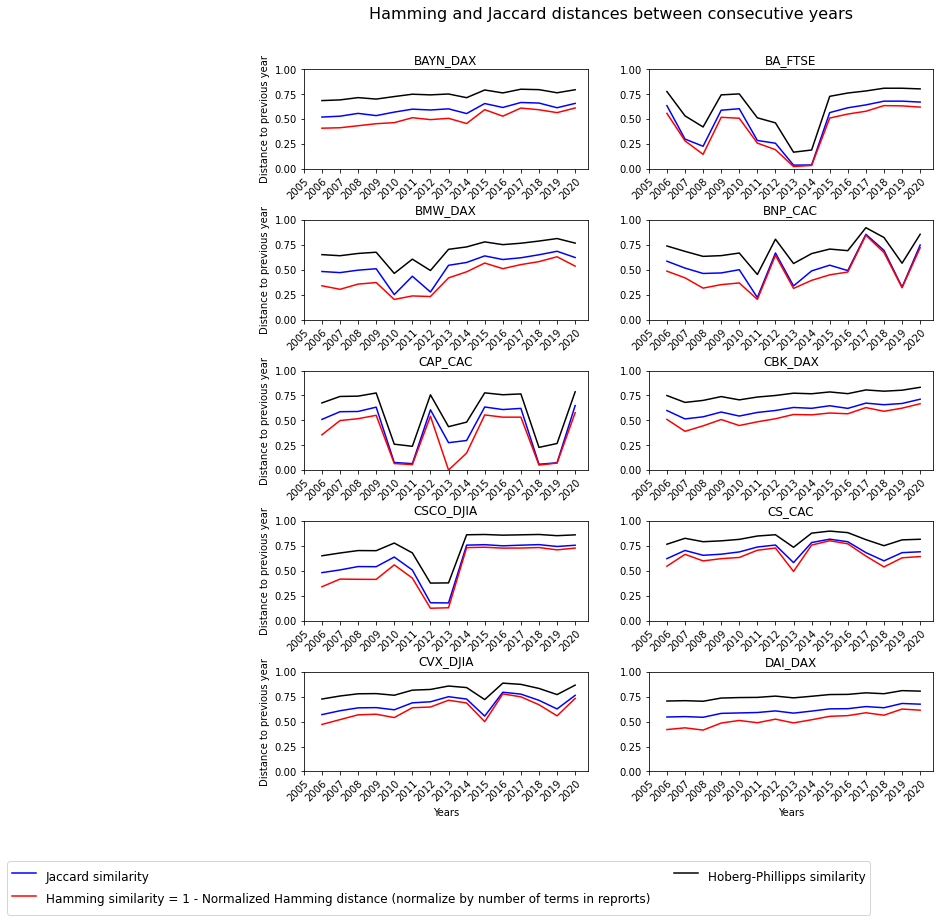

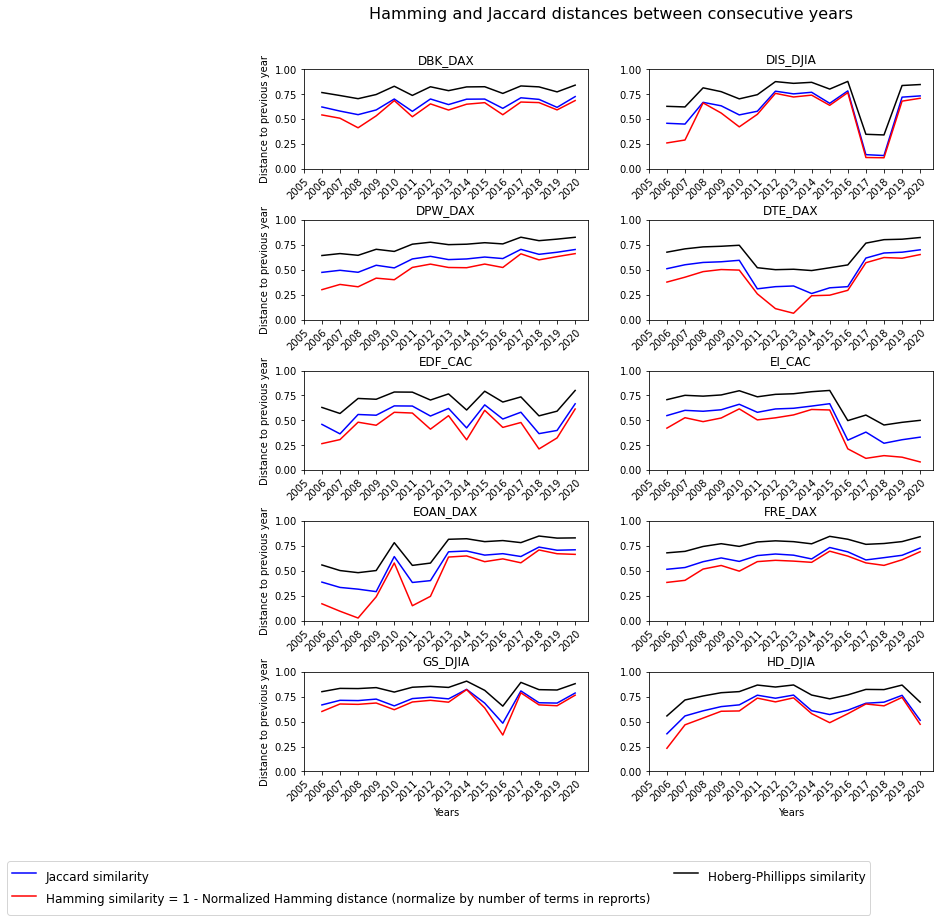

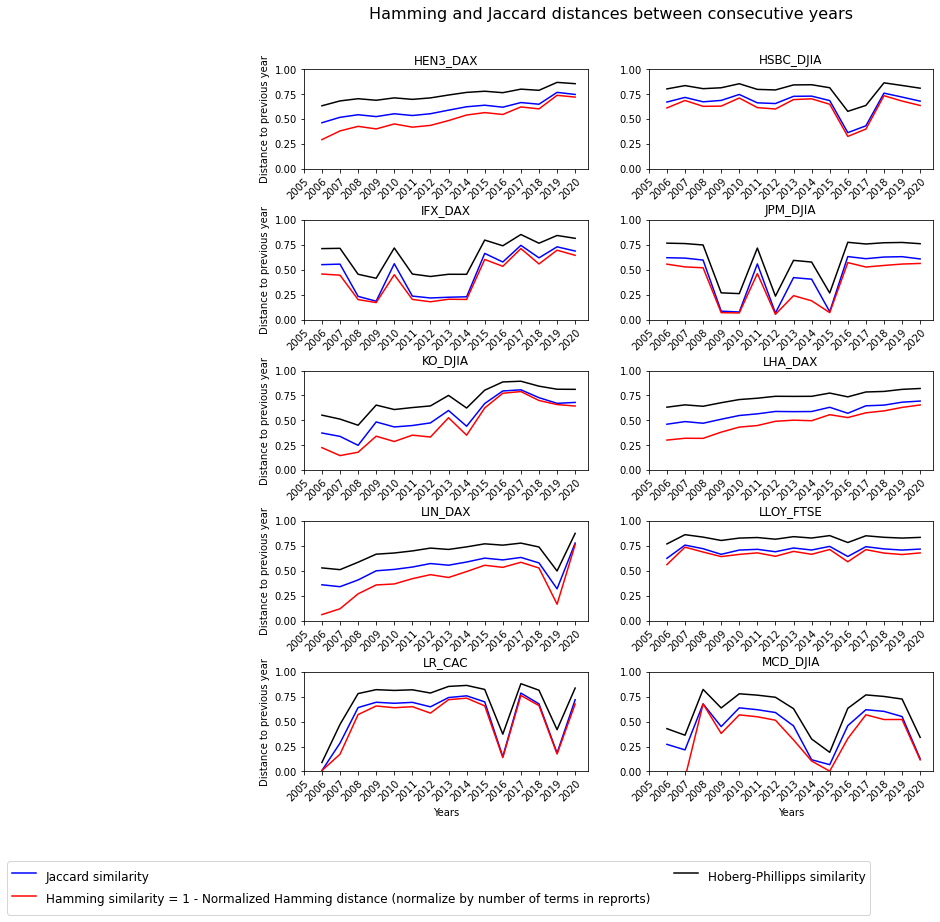

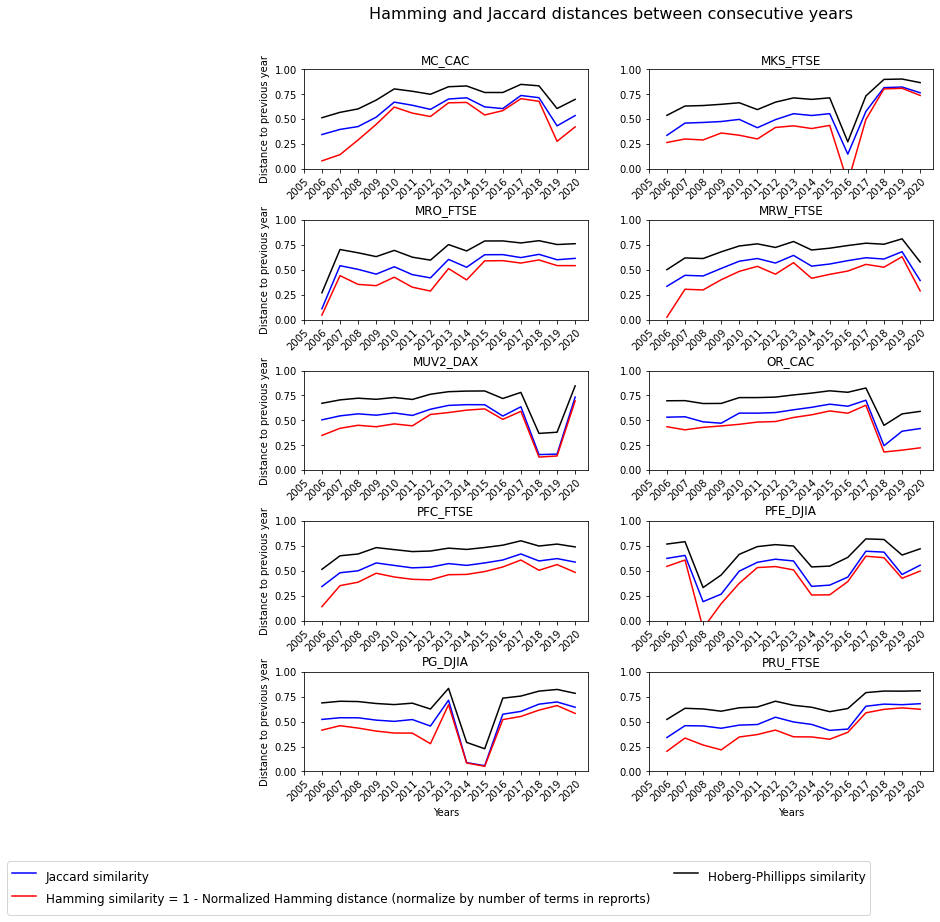

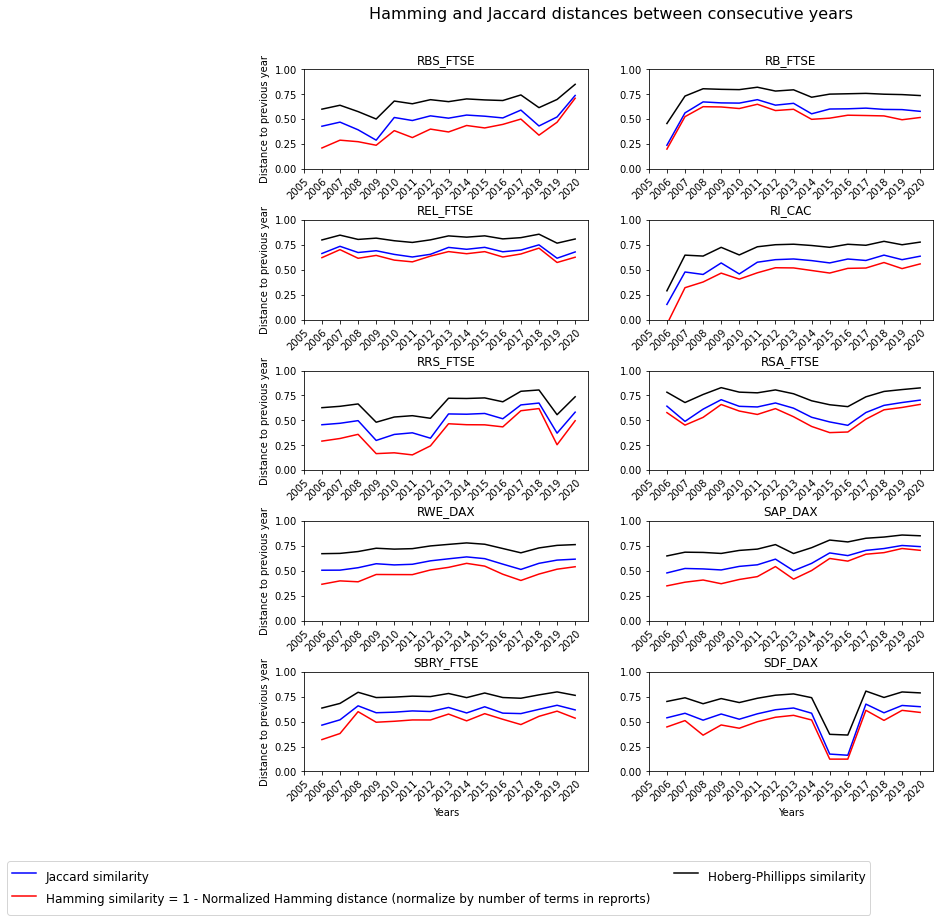

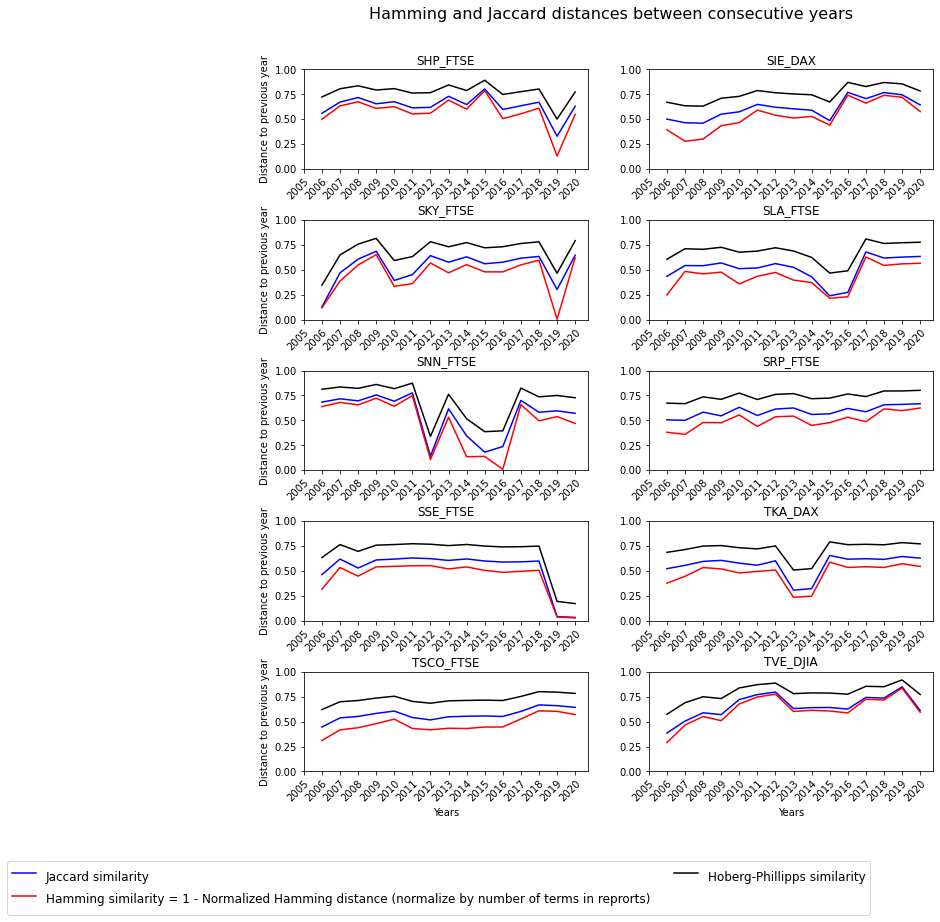

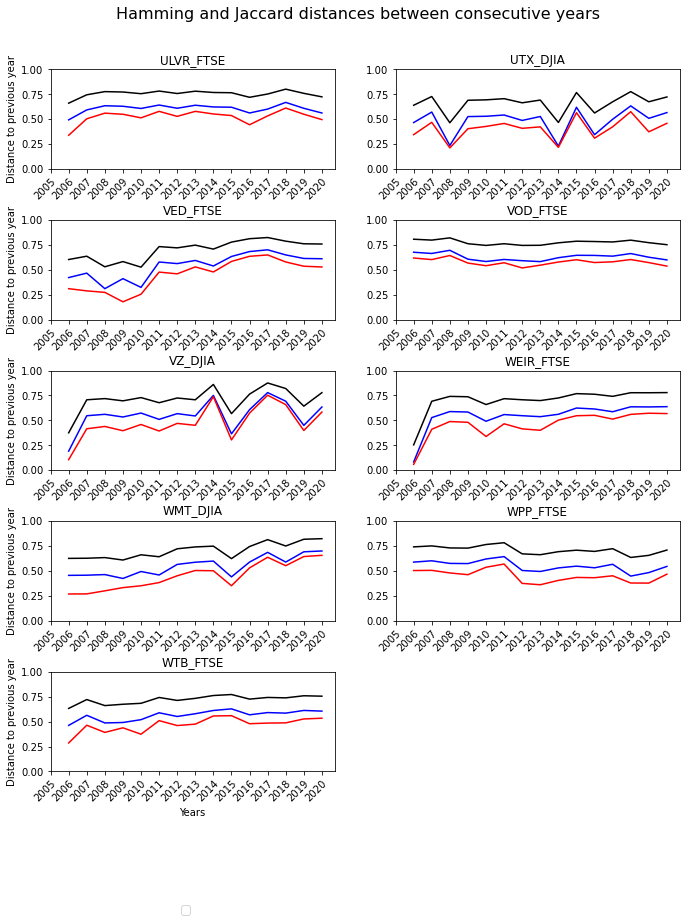

In [44]:
global_ticker_iterator = 0

bar_width = 1
bar_l = [i for i in range(len(year_series))]
tick_pos = [i for i in bar_l]

for page in range(number_of_pages):
    
    f, axs = plt.subplots(
        rows_on_page,
        columns_on_page,
        figsize=(10,11.5), # A4 landscape(11.69,8.27)
        ) 
    
    f.suptitle('Hamming and Jaccard distances between consecutive years', fontsize=16)
    f.tight_layout(pad=3.0)
    for row_index in range(rows_on_page):
        for column_index in range(columns_on_page):
            ax = axs[row_index][column_index]
            
            if global_ticker_iterator >= len(tickers_list):
                ax.axis('off')
                continue

            if column_index == 0:
                ax.set_ylabel("Distance to previous year")
            if row_index ==  rows_on_page - 1:
                ax.set_xlabel("Years")
                
            ticker = tickers_list[global_ticker_iterator]
            ax.set_title('%s' % (ticker))


            # data construction
            ticker_p_years = P_by_year[ticker]
            ticker_v_years = V_by_year[ticker]            
            ## jaccard
            data_jaccard = [None]
            for i in range(1, len(year_series)):
                data_jaccard.append(jaccard_similarity(ticker_p_years[year_series[i - 1]], ticker_p_years[year_series[i]]))
            ax.plot(np.asarray(data_jaccard, dtype=np.float64), color='blue', label='Jaccard similarity')
            
            ## hamming
            data_hamming = [None]
            for i in range(1, len(year_series)):
                data_hamming.append(hamming_distance(ticker_p_years[year_series[i - 1]], ticker_p_years[year_series[i]], assimilarity=True))
            ax.plot(np.asarray(data_hamming, dtype=np.float64), color='red', label='Hamming similarity = 1 - Normalized Hamming distance (normalize by number of terms in reprorts)')
            
            ## hamming
            data_hp_sim = [None]
            for i in range(1, len(year_series)):
                data_hp_sim.append(hp_similarity(ticker_v_years[year_series[i - 1]], ticker_v_years[year_series[i]]))
            ax.plot(np.asarray(data_hp_sim, dtype=np.float64), color='black', label='Hoberg-Phillipps similarity')
            
            ax.set_ylim(0, 1)
            ax.set_xticks(tick_pos)
            ax.set_xticklabels(year_series, rotation=45, rotation_mode="anchor", horizontalalignment='right')
            
            global_ticker_iterator += 1
            
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, 
        bbox_to_anchor=(-0.74, -1.5), 
        loc="lower center", 
        ncol=2, 
        handleheight=2.4, 
        labelspacing=0.05, prop={'size': 12})
        
    #save plot
    pp = PdfPages(os.path.join(dir_hp_similarity_plots, 'hp_similarity_on_page_%s.pdf' % page))
    plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    pp.close()
    
    plt.show()
    plt.close()


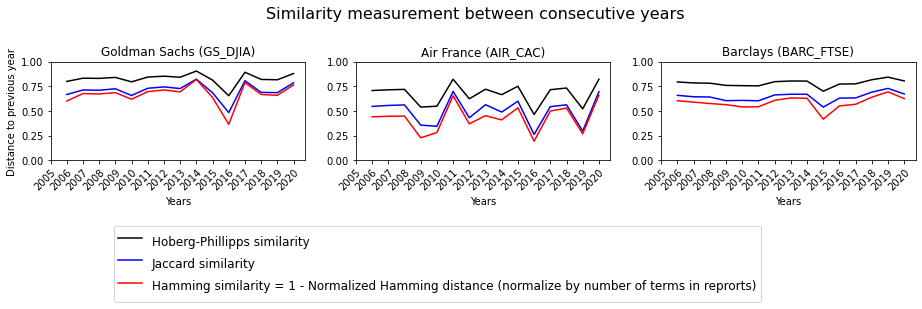

In [76]:
global_ticker_iterator = 0
three_tickers = ['GS_DJIA', 'AIR_CAC', 'BARC_FTSE']
bar_width = 1
bar_l = [i for i in range(len(year_series))]
tick_pos = [i for i in bar_l]

f, axs = plt.subplots(
    1,
    3,
    figsize=(13,2.7), # A4 landscape(11.69,8.27)
    ) 
    
f.suptitle('Similarity measurement between consecutive years', fontsize=16)
f.tight_layout(pad=2.0)

for column_index in range(3):
    ax = axs[column_index]
    
    ax.set_xlabel("Years")
    if column_index == 0:
        ax.set_ylabel("Distance to previous year")

    ticker = three_tickers[global_ticker_iterator]
    ax.set_title('%s (%s)' % (companies_names[ticker], ticker))


    # data construction
    ticker_p_years = P_by_year[ticker]
    ticker_v_years = V_by_year[ticker]            

    ## HP
    data_hp_sim = [None]
    for i in range(1, len(year_series)):
        data_hp_sim.append(hp_similarity(ticker_v_years[year_series[i - 1]], ticker_v_years[year_series[i]]))
    ax.plot(np.asarray(data_hp_sim, dtype=np.float64), color='black', label='Hoberg-Phillipps similarity')
    ## jaccard
    data_jaccard = [None]
    for i in range(1, len(year_series)):
        data_jaccard.append(jaccard_similarity(ticker_p_years[year_series[i - 1]], ticker_p_years[year_series[i]]))
    ax.plot(np.asarray(data_jaccard, dtype=np.float64), color='blue', label='Jaccard similarity')
    ## hamming
    data_hamming = [None]
    for i in range(1, len(year_series)):
        data_hamming.append(hamming_distance(ticker_p_years[year_series[i - 1]], ticker_p_years[year_series[i]], assimilarity=True))
    ax.plot(np.asarray(data_hamming, dtype=np.float64), color='red', label='Hamming similarity = 1 - Normalized Hamming distance (normalize by number of terms in reprorts)')

    
    ax.set_ylim(0, 1)
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(year_series, rotation=45, rotation_mode="anchor", horizontalalignment='right')

    global_ticker_iterator += 1
            
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, 
    bbox_to_anchor=(-0.88, -1.5), 
    loc="lower center", 
    ncol=1, 
    handleheight=2.4, 
    labelspacing=0.05, prop={'size': 12})

#save plot
pp = PdfPages(os.path.join(dir_hp_similarity_plots, 'similarity_panel_of_three.pdf'))
plt.savefig(pp, format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
pp.close()

plt.show()
plt.close()


Create a df with hamming distance

In [ ]:
print(tickers_list)